In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 1000,
    'patience'      : 7,
    'dropout'       : 0.75,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_1000_075_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_b25_t1_mask_t1t2_normalized_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 920)
(734160, 1)
validation
(101248, 920)
(101248, 1)
test
(100432, 920)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 920)]             0         


 dense (Dense)               (None, 1024)              943104    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1632257 (6.23 MB)


Trainable params: 1632257 (6.23 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/735 [..............................] - ETA: 12:30 - loss: 0.1886 - STD: 1.2165e-04 - MAE: 0.4241

 15/735 [..............................] - ETA: 2s - loss: 0.0359 - STD: 9.9924e-05 - MAE: 0.1473   

 30/735 [>.............................] - ETA: 2s - loss: 0.0252 - STD: 6.5222e-05 - MAE: 0.1198

 45/735 [>.............................] - ETA: 2s - loss: 0.0202 - STD: 4.7455e-05 - MAE: 0.1066

 59/735 [=>............................] - ETA: 2s - loss: 0.0177 - STD: 3.7712e-05 - MAE: 0.0996

 68/735 [=>............................] - ETA: 6s - loss: 0.0167 - STD: 3.3563e-05 - MAE: 0.0967

 83/735 [==>...........................] - ETA: 5s - loss: 0.0154 - STD: 2.8711e-05 - MAE: 0.0927

 97/735 [==>...........................] - ETA: 5s - loss: 0.0144 - STD: 2.5763e-05 - MAE: 0.0903

109/735 [===>..........................] - ETA: 4s - loss: 0.0139 - STD: 2.4021e-05 - MAE: 0.0887

122/735 [===>..........................] - ETA: 4s - loss: 0.0134 - STD: 2.2642e-05 - MAE: 0.0871

135/735 [====>.........................] - ETA: 4s - loss: 0.0130 - STD: 2.1743e-05 - MAE: 0.0860

146/735 [====>.........................] - ETA: 3s - loss: 0.0127 - STD: 2.1402e-05 - MAE: 0.0853

158/735 [=====>........................] - ETA: 3s - loss: 0.0124 - STD: 2.1228e-05 - MAE: 0.0845

170/735 [=====>........................] - ETA: 3s - loss: 0.0122 - STD: 2.1554e-05 - MAE: 0.0840

182/735 [======>.......................] - ETA: 3s - loss: 0.0120 - STD: 2.2275e-05 - MAE: 0.0834

194/735 [======>.......................] - ETA: 3s - loss: 0.0119 - STD: 2.3434e-05 - MAE: 0.0829

206/735 [=======>......................] - ETA: 3s - loss: 0.0117 - STD: 2.5223e-05 - MAE: 0.0825

218/735 [=======>......................] - ETA: 3s - loss: 0.0116 - STD: 2.7779e-05 - MAE: 0.0822

230/735 [========>.....................] - ETA: 2s - loss: 0.0115 - STD: 3.1496e-05 - MAE: 0.0818

244/735 [========>.....................] - ETA: 2s - loss: 0.0113 - STD: 3.7557e-05 - MAE: 0.0814

255/735 [=========>....................] - ETA: 2s - loss: 0.0112 - STD: 4.4360e-05 - MAE: 0.0812

267/735 [=========>....................] - ETA: 2s - loss: 0.0111 - STD: 5.4874e-05 - MAE: 0.0809

279/735 [==========>...................] - ETA: 2s - loss: 0.0110 - STD: 7.0714e-05 - MAE: 0.0807

291/735 [==========>...................] - ETA: 2s - loss: 0.0110 - STD: 9.5679e-05 - MAE: 0.0805

304/735 [===========>..................] - ETA: 2s - loss: 0.0109 - STD: 1.4071e-04 - MAE: 0.0802

318/735 [===========>..................] - ETA: 2s - loss: 0.0108 - STD: 2.3051e-04 - MAE: 0.0800

331/735 [============>.................] - ETA: 2s - loss: 0.0107 - STD: 3.8736e-04 - MAE: 0.0797

346/735 [=============>................] - ETA: 2s - loss: 0.0106 - STD: 7.4517e-04 - MAE: 0.0795

361/735 [=============>................] - ETA: 1s - loss: 0.0105 - STD: 0.0014 - MAE: 0.0791    

373/735 [==============>...............] - ETA: 1s - loss: 0.0104 - STD: 0.0023 - MAE: 0.0787

385/735 [==============>...............] - ETA: 1s - loss: 0.0103 - STD: 0.0034 - MAE: 0.0783

397/735 [===============>..............] - ETA: 1s - loss: 0.0102 - STD: 0.0046 - MAE: 0.0778

412/735 [===============>..............] - ETA: 1s - loss: 0.0101 - STD: 0.0062 - MAE: 0.0772

425/735 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 0.0076 - MAE: 0.0766

437/735 [================>.............] - ETA: 1s - loss: 0.0098 - STD: 0.0088 - MAE: 0.0761

449/735 [=================>............] - ETA: 1s - loss: 0.0097 - STD: 0.0100 - MAE: 0.0757

462/735 [=================>............] - ETA: 1s - loss: 0.0096 - STD: 0.0113 - MAE: 0.0752

475/735 [==================>...........] - ETA: 1s - loss: 0.0095 - STD: 0.0126 - MAE: 0.0747

488/735 [==================>...........] - ETA: 1s - loss: 0.0094 - STD: 0.0138 - MAE: 0.0742

500/735 [===================>..........] - ETA: 1s - loss: 0.0093 - STD: 0.0149 - MAE: 0.0738

512/735 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 0.0160 - MAE: 0.0733

524/735 [====================>.........] - ETA: 1s - loss: 0.0091 - STD: 0.0170 - MAE: 0.0729

538/735 [====================>.........] - ETA: 0s - loss: 0.0090 - STD: 0.0182 - MAE: 0.0724

551/735 [=====================>........] - ETA: 0s - loss: 0.0089 - STD: 0.0192 - MAE: 0.0719

564/735 [======================>.......] - ETA: 0s - loss: 0.0088 - STD: 0.0202 - MAE: 0.0715

576/735 [======================>.......] - ETA: 0s - loss: 0.0087 - STD: 0.0211 - MAE: 0.0712

588/735 [=======================>......] - ETA: 0s - loss: 0.0086 - STD: 0.0218 - MAE: 0.0708

601/735 [=======================>......] - ETA: 0s - loss: 0.0085 - STD: 0.0227 - MAE: 0.0704

617/735 [========================>.....] - ETA: 0s - loss: 0.0085 - STD: 0.0237 - MAE: 0.0700

632/735 [========================>.....] - ETA: 0s - loss: 0.0084 - STD: 0.0247 - MAE: 0.0696

645/735 [=========================>....] - ETA: 0s - loss: 0.0083 - STD: 0.0255 - MAE: 0.0693

658/735 [=========================>....] - ETA: 0s - loss: 0.0082 - STD: 0.0262 - MAE: 0.0690

672/735 [==========================>...] - ETA: 0s - loss: 0.0082 - STD: 0.0270 - MAE: 0.0686

685/735 [==========================>...] - ETA: 0s - loss: 0.0081 - STD: 0.0277 - MAE: 0.0683

697/735 [===========================>..] - ETA: 0s - loss: 0.0080 - STD: 0.0284 - MAE: 0.0680

709/735 [===========================>..] - ETA: 0s - loss: 0.0080 - STD: 0.0290 - MAE: 0.0677

722/735 [============================>.] - ETA: 0s - loss: 0.0079 - STD: 0.0297 - MAE: 0.0674

733/735 [============================>.] - ETA: 0s - loss: 0.0079 - STD: 0.0302 - MAE: 0.0672

735/735 [==============================] - 5s 6ms/step - loss: 0.0079 - STD: 0.0303 - MAE: 0.0672 - val_loss: 0.0037 - val_STD: 0.0472 - val_MAE: 0.0467


Epoch 2/10000


  1/735 [..............................] - ETA: 14s - loss: 0.0046 - STD: 0.0679 - MAE: 0.0513

 16/735 [..............................] - ETA: 2s - loss: 0.0046 - STD: 0.0670 - MAE: 0.0514 

 32/735 [>.............................] - ETA: 2s - loss: 0.0046 - STD: 0.0668 - MAE: 0.0516

 48/735 [>.............................] - ETA: 2s - loss: 0.0046 - STD: 0.0668 - MAE: 0.0514

 64/735 [=>............................] - ETA: 2s - loss: 0.0046 - STD: 0.0670 - MAE: 0.0513

 77/735 [==>...........................] - ETA: 2s - loss: 0.0046 - STD: 0.0671 - MAE: 0.0513

 90/735 [==>...........................] - ETA: 2s - loss: 0.0046 - STD: 0.0671 - MAE: 0.0513

106/735 [===>..........................] - ETA: 2s - loss: 0.0046 - STD: 0.0670 - MAE: 0.0512

121/735 [===>..........................] - ETA: 2s - loss: 0.0045 - STD: 0.0671 - MAE: 0.0511

137/735 [====>.........................] - ETA: 2s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0509

152/735 [=====>........................] - ETA: 1s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0510

169/735 [=====>........................] - ETA: 1s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0510

186/735 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0509

203/735 [=======>......................] - ETA: 1s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0508

217/735 [=======>......................] - ETA: 1s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0508

233/735 [========>.....................] - ETA: 1s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0507

250/735 [=========>....................] - ETA: 1s - loss: 0.0045 - STD: 0.0678 - MAE: 0.0507

265/735 [=========>....................] - ETA: 1s - loss: 0.0045 - STD: 0.0679 - MAE: 0.0506

279/735 [==========>...................] - ETA: 1s - loss: 0.0045 - STD: 0.0680 - MAE: 0.0506

293/735 [==========>...................] - ETA: 1s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0505

309/735 [===========>..................] - ETA: 1s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0505

325/735 [============>.................] - ETA: 1s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0504

342/735 [============>.................] - ETA: 1s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0503

358/735 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0503

375/735 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0502

392/735 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0502

409/735 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0501

424/735 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0500

438/735 [================>.............] - ETA: 0s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0500

450/735 [=================>............] - ETA: 0s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0499

465/735 [=================>............] - ETA: 0s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0499

479/735 [==================>...........] - ETA: 0s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0499

492/735 [===================>..........] - ETA: 0s - loss: 0.0044 - STD: 0.0687 - MAE: 0.0499

508/735 [===================>..........] - ETA: 0s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0498

523/735 [====================>.........] - ETA: 0s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0498

536/735 [====================>.........] - ETA: 0s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0497

549/735 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0497

561/735 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0496

574/735 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0496

586/735 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0496

599/735 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0495

613/735 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0495

630/735 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0494

646/735 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0494

662/735 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0494

679/735 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0493

693/735 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0493

705/735 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0492

719/735 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0492

735/735 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0491

735/735 [==============================] - 3s 4ms/step - loss: 0.0042 - STD: 0.0694 - MAE: 0.0491 - val_loss: 0.0033 - val_STD: 0.0540 - val_MAE: 0.0433


Epoch 3/10000


  1/735 [..............................] - ETA: 13s - loss: 0.0039 - STD: 0.0738 - MAE: 0.0473

 16/735 [..............................] - ETA: 2s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0472 

 31/735 [>.............................] - ETA: 2s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0473

 46/735 [>.............................] - ETA: 2s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0476

 62/735 [=>............................] - ETA: 2s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0475

 79/735 [==>...........................] - ETA: 2s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0473

 91/735 [==>...........................] - ETA: 2s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0472

103/735 [===>..........................] - ETA: 2s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0471

117/735 [===>..........................] - ETA: 2s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0471

133/735 [====>.........................] - ETA: 2s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0471

149/735 [=====>........................] - ETA: 2s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0471

164/735 [=====>........................] - ETA: 2s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0471

180/735 [======>.......................] - ETA: 1s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0470

195/735 [======>.......................] - ETA: 1s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0469

210/735 [=======>......................] - ETA: 1s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0469

222/735 [========>.....................] - ETA: 1s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0469

237/735 [========>.....................] - ETA: 1s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0468

253/735 [=========>....................] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0467

270/735 [==========>...................] - ETA: 1s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0466

286/735 [==========>...................] - ETA: 1s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0466

302/735 [===========>..................] - ETA: 1s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0466

319/735 [============>.................] - ETA: 1s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0466

335/735 [============>.................] - ETA: 1s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0465

350/735 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0465

364/735 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0464

379/735 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0464

396/735 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0463

412/735 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0463

427/735 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

442/735 [=================>............] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0462

458/735 [=================>............] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0462

475/735 [==================>...........] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0461

492/735 [===================>..........] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0461

509/735 [===================>..........] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0461

526/735 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0461

542/735 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0460

558/735 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0460

574/735 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0460

590/735 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0460

606/735 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0460

622/735 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0460

638/735 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0460

654/735 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0460

671/735 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0459

688/735 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0459

704/735 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0459

720/735 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0459

735/735 [==============================] - 3s 4ms/step - loss: 0.0037 - STD: 0.0732 - MAE: 0.0459 - val_loss: 0.0031 - val_STD: 0.0610 - val_MAE: 0.0416


Epoch 4/10000


  1/735 [..............................] - ETA: 12s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0440

 16/735 [..............................] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0452 

 31/735 [>.............................] - ETA: 2s - loss: 0.0037 - STD: 0.0743 - MAE: 0.0455

 43/735 [>.............................] - ETA: 2s - loss: 0.0037 - STD: 0.0748 - MAE: 0.0454

 55/735 [=>............................] - ETA: 2s - loss: 0.0037 - STD: 0.0746 - MAE: 0.0453

 70/735 [=>............................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0451

 83/735 [==>...........................] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0449

 95/735 [==>...........................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0448

108/735 [===>..........................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0447

125/735 [====>.........................] - ETA: 2s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0446

141/735 [====>.........................] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0445

156/735 [=====>........................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0444

168/735 [=====>........................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0444

180/735 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0444

193/735 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0444

206/735 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0444

221/735 [========>.....................] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0443

235/735 [========>.....................] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

251/735 [=========>....................] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

266/735 [=========>....................] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

281/735 [==========>...................] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0443

295/735 [===========>..................] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0443

310/735 [===========>..................] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

322/735 [============>.................] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0442

333/735 [============>.................] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0442

345/735 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

359/735 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

373/735 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

386/735 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

398/735 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

410/735 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

422/735 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

436/735 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

451/735 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

464/735 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

479/735 [==================>...........] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

494/735 [===================>..........] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

507/735 [===================>..........] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

521/735 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

536/735 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

550/735 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

563/735 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

575/735 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0439

587/735 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0439

599/735 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0438

612/735 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0438

625/735 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0438

637/735 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0438

648/735 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0438

660/735 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0437

674/735 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0437

688/735 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0438

700/735 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0438

712/735 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0437

726/735 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0437

735/735 [==============================] - 3s 4ms/step - loss: 0.0034 - STD: 0.0755 - MAE: 0.0437 - val_loss: 0.0031 - val_STD: 0.0644 - val_MAE: 0.0409


Epoch 5/10000


  1/735 [..............................] - ETA: 14s - loss: 0.0031 - STD: 0.0803 - MAE: 0.0423

 15/735 [..............................] - ETA: 2s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0448 

 30/735 [>.............................] - ETA: 2s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0447

 46/735 [>.............................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0442

 60/735 [=>............................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

 73/735 [=>............................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

 84/735 [==>...........................] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

 96/735 [==>...........................] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

109/735 [===>..........................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

121/735 [===>..........................] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

132/735 [====>.........................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

144/735 [====>.........................] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

157/735 [=====>........................] - ETA: 2s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0431

172/735 [======>.......................] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0430

187/735 [======>.......................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0430

202/735 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

215/735 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0430

228/735 [========>.....................] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0431

243/735 [========>.....................] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

259/735 [=========>....................] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0431

274/735 [==========>...................] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0431

286/735 [==========>...................] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0430

297/735 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0430

309/735 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0430

322/735 [============>.................] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0430

337/735 [============>.................] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

351/735 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

366/735 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

382/735 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

398/735 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

414/735 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

429/735 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

442/735 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

458/735 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

473/735 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

488/735 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

503/735 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

518/735 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

533/735 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

549/735 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

565/735 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

581/735 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

597/735 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

613/735 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

628/735 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

642/735 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

656/735 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

670/735 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

683/735 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

696/735 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

711/735 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

727/735 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

735/735 [==============================] - 3s 4ms/step - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425 - val_loss: 0.0033 - val_STD: 0.0595 - val_MAE: 0.0418


Epoch 6/10000


  1/735 [..............................] - ETA: 16s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0421

 15/735 [..............................] - ETA: 2s - loss: 0.0033 - STD: 0.0777 - MAE: 0.0425 

 31/735 [>.............................] - ETA: 2s - loss: 0.0032 - STD: 0.0783 - MAE: 0.0420

 44/735 [>.............................] - ETA: 2s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0419

 60/735 [=>............................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0421

 76/735 [==>...........................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0420

 91/735 [==>...........................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0421

106/735 [===>..........................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

122/735 [===>..........................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

137/735 [====>.........................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

153/735 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0416

169/735 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0416

184/735 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0416

199/735 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0416

214/735 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0416

230/735 [========>.....................] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0416

246/735 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0415

262/735 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0416

278/735 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0416

293/735 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0416

308/735 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0416

323/735 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0416

337/735 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0416

352/735 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0416

366/735 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0416

378/735 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0416

390/735 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0416

404/735 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0416

417/735 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0416

431/735 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0416

443/735 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0416

458/735 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0416

473/735 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0415

487/735 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0416

499/735 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0416

512/735 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0416

526/735 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0416

538/735 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0415

550/735 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0415

563/735 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0415

578/735 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0415

591/735 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0415

603/735 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0415

617/735 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0415

631/735 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0415

645/735 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

658/735 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

673/735 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

687/735 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

701/735 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

713/735 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

726/735 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

735/735 [==============================] - 3s 4ms/step - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414 - val_loss: 0.0033 - val_STD: 0.0596 - val_MAE: 0.0417


Epoch 7/10000


  1/735 [..............................] - ETA: 14s - loss: 0.0030 - STD: 0.0715 - MAE: 0.0402

 15/735 [..............................] - ETA: 2s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0412 

 27/735 [>.............................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0414

 39/735 [>.............................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

 51/735 [=>............................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0414

 65/735 [=>............................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0417

 80/735 [==>...........................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

 92/735 [==>...........................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0414

104/735 [===>..........................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

118/735 [===>..........................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

130/735 [====>.........................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

143/735 [====>.........................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0411

156/735 [=====>........................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

168/735 [=====>........................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0411

182/735 [======>.......................] - ETA: 2s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0411

195/735 [======>.......................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0411

207/735 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0411

220/735 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

233/735 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

246/735 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

261/735 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

276/735 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

291/735 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

307/735 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0409

322/735 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

338/735 [============>.................] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0409

353/735 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0409

369/735 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0409

383/735 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

399/735 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0408

414/735 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0408

427/735 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0408

439/735 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0408

452/735 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

468/735 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

485/735 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

502/735 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0408

519/735 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

535/735 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

551/735 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

566/735 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

582/735 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

598/735 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

615/735 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

631/735 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

646/735 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

663/735 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

677/735 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

693/735 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

708/735 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

723/735 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

735/735 [==============================] - 3s 4ms/step - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406 - val_loss: 0.0030 - val_STD: 0.0682 - val_MAE: 0.0399


Epoch 8/10000


  1/735 [..............................] - ETA: 12s - loss: 0.0027 - STD: 0.0839 - MAE: 0.0389

 13/735 [..............................] - ETA: 3s - loss: 0.0029 - STD: 0.0777 - MAE: 0.0396 

 25/735 [>.............................] - ETA: 3s - loss: 0.0028 - STD: 0.0784 - MAE: 0.0395

 41/735 [>.............................] - ETA: 2s - loss: 0.0028 - STD: 0.0787 - MAE: 0.0395

 56/735 [=>............................] - ETA: 2s - loss: 0.0028 - STD: 0.0786 - MAE: 0.0395

 71/735 [=>............................] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

 86/735 [==>...........................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

 99/735 [===>..........................] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

111/735 [===>..........................] - ETA: 2s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0398

125/735 [====>.........................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

140/735 [====>.........................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

153/735 [=====>........................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

166/735 [=====>........................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

180/735 [======>.......................] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

192/735 [======>.......................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

205/735 [=======>......................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

217/735 [=======>......................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

230/735 [========>.....................] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

242/735 [========>.....................] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

257/735 [=========>....................] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

272/735 [==========>...................] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

287/735 [==========>...................] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

301/735 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

315/735 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

327/735 [============>.................] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

341/735 [============>.................] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

355/735 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

367/735 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

381/735 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

396/735 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0400

407/735 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

418/735 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

432/735 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

446/735 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0400

459/735 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

475/735 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

492/735 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

508/735 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

524/735 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

540/735 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

556/735 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

572/735 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

588/735 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

604/735 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

620/735 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

635/735 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

651/735 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

667/735 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

683/735 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

695/735 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

709/735 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

725/735 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

735/735 [==============================] - 3s 4ms/step - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398 - val_loss: 0.0030 - val_STD: 0.0698 - val_MAE: 0.0405


Epoch 9/10000


  1/735 [..............................] - ETA: 12s - loss: 0.0027 - STD: 0.0854 - MAE: 0.0386

 15/735 [..............................] - ETA: 2s - loss: 0.0028 - STD: 0.0806 - MAE: 0.0393 

 31/735 [>.............................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0393

 45/735 [>.............................] - ETA: 2s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0394

 57/735 [=>............................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0393

 70/735 [=>............................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0393

 83/735 [==>...........................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0393

 99/735 [===>..........................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0394

116/735 [===>..........................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0393

132/735 [====>.........................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

148/735 [=====>........................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

163/735 [=====>........................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

180/735 [======>.......................] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

195/735 [======>.......................] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

210/735 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0393

226/735 [========>.....................] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0394

242/735 [========>.....................] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0393

258/735 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0393

274/735 [==========>...................] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0393

290/735 [==========>...................] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0393

306/735 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0393

322/735 [============>.................] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0393

337/735 [============>.................] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

353/735 [=============>................] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

370/735 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0393

387/735 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0393

404/735 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0393

420/735 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0393

436/735 [================>.............] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

453/735 [=================>............] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

470/735 [==================>...........] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

487/735 [==================>...........] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

504/735 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

519/735 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

531/735 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

545/735 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

559/735 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

573/735 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

584/735 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

595/735 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

606/735 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

617/735 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

631/735 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

646/735 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

661/735 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

676/735 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

691/735 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

705/735 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

719/735 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

734/735 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

735/735 [==============================] - 3s 4ms/step - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391 - val_loss: 0.0030 - val_STD: 0.0675 - val_MAE: 0.0399


Epoch 10/10000


  1/735 [..............................] - ETA: 16s - loss: 0.0028 - STD: 0.0806 - MAE: 0.0391

 14/735 [..............................] - ETA: 2s - loss: 0.0028 - STD: 0.0821 - MAE: 0.0386 

 30/735 [>.............................] - ETA: 2s - loss: 0.0028 - STD: 0.0807 - MAE: 0.0386

 46/735 [>.............................] - ETA: 2s - loss: 0.0028 - STD: 0.0803 - MAE: 0.0387

 62/735 [=>............................] - ETA: 2s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0386

 78/735 [==>...........................] - ETA: 2s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0386

 93/735 [==>...........................] - ETA: 2s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0386

108/735 [===>..........................] - ETA: 2s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0386

123/735 [====>.........................] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0387

138/735 [====>.........................] - ETA: 2s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0387

154/735 [=====>........................] - ETA: 1s - loss: 0.0028 - STD: 0.0803 - MAE: 0.0387

170/735 [=====>........................] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0387

186/735 [======>.......................] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0387

202/735 [=======>......................] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0387

218/735 [=======>......................] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0386

234/735 [========>.....................] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0386

251/735 [=========>....................] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0386

267/735 [=========>....................] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

282/735 [==========>...................] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

298/735 [===========>..................] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

313/735 [===========>..................] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

329/735 [============>.................] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

346/735 [=============>................] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0386

363/735 [=============>................] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

378/735 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

393/735 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0386

409/735 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

425/735 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

441/735 [=================>............] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

457/735 [=================>............] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

474/735 [==================>...........] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

491/735 [===================>..........] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

507/735 [===================>..........] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

520/735 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

532/735 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

547/735 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

561/735 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

578/735 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

593/735 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

607/735 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

619/735 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

633/735 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

646/735 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

661/735 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

677/735 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

692/735 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

704/735 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

716/735 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

731/735 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

735/735 [==============================] - 3s 4ms/step - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384 - val_loss: 0.0030 - val_STD: 0.0656 - val_MAE: 0.0397


Epoch 11/10000


  1/735 [..............................] - ETA: 14s - loss: 0.0026 - STD: 0.0783 - MAE: 0.0370

 15/735 [..............................] - ETA: 2s - loss: 0.0027 - STD: 0.0811 - MAE: 0.0380 

 31/735 [>.............................] - ETA: 2s - loss: 0.0027 - STD: 0.0817 - MAE: 0.0379

 47/735 [>.............................] - ETA: 2s - loss: 0.0027 - STD: 0.0816 - MAE: 0.0377

 61/735 [=>............................] - ETA: 2s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0377

 74/735 [==>...........................] - ETA: 2s - loss: 0.0027 - STD: 0.0814 - MAE: 0.0378

 86/735 [==>...........................] - ETA: 2s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0379

100/735 [===>..........................] - ETA: 2s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0378

112/735 [===>..........................] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0378

124/735 [====>.........................] - ETA: 2s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0378

137/735 [====>.........................] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0377

150/735 [=====>........................] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0378

162/735 [=====>........................] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0378

174/735 [======>.......................] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0379

186/735 [======>.......................] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0379

197/735 [=======>......................] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0378

210/735 [=======>......................] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0379

222/735 [========>.....................] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0379

233/735 [========>.....................] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0378

244/735 [========>.....................] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0379

258/735 [=========>....................] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0378

274/735 [==========>...................] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0378

290/735 [==========>...................] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0378

306/735 [===========>..................] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0378

323/735 [============>.................] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0379

340/735 [============>.................] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0380

356/735 [=============>................] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0381

370/735 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0381

386/735 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0381

401/735 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0380

414/735 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0380

430/735 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0380

446/735 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0380

463/735 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0380

479/735 [==================>...........] - ETA: 0s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0380

496/735 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0379

510/735 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0379

524/735 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0379

539/735 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0379

554/735 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0379

570/735 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0378

586/735 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0378

601/735 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0378

616/735 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

630/735 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

643/735 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

655/735 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

667/735 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

678/735 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

691/735 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

708/735 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

724/735 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

735/735 [==============================] - 3s 4ms/step - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378 - val_loss: 0.0030 - val_STD: 0.0718 - val_MAE: 0.0400


Epoch 12/10000


  1/735 [..............................] - ETA: 15s - loss: 0.0024 - STD: 0.0860 - MAE: 0.0368

 14/735 [..............................] - ETA: 2s - loss: 0.0026 - STD: 0.0828 - MAE: 0.0380 

 29/735 [>.............................] - ETA: 2s - loss: 0.0027 - STD: 0.0812 - MAE: 0.0382

 42/735 [>.............................] - ETA: 2s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0387

 54/735 [=>............................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0387

 66/735 [=>............................] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0385

 80/735 [==>...........................] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0384

 93/735 [==>...........................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

106/735 [===>..........................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

121/735 [===>..........................] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

138/735 [====>.........................] - ETA: 2s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0380

152/735 [=====>........................] - ETA: 2s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0378

166/735 [=====>........................] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

182/735 [======>.......................] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0378

198/735 [=======>......................] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0377

214/735 [=======>......................] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0377

229/735 [========>.....................] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

244/735 [========>.....................] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

259/735 [=========>....................] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0376

275/735 [==========>...................] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0375

292/735 [==========>...................] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0375

308/735 [===========>..................] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0375

322/735 [============>.................] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

338/735 [============>.................] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0375

354/735 [=============>................] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0375

370/735 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0375

385/735 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0375

400/735 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0375

415/735 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

430/735 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

445/735 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

460/735 [=================>............] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

476/735 [==================>...........] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

491/735 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0373

506/735 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0373

521/735 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0373

537/735 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0373

552/735 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0373

567/735 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0373

583/735 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0372

600/735 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0372

616/735 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0372

633/735 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0372

648/735 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0372

662/735 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0372

678/735 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0372

692/735 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0372

707/735 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0372

722/735 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0372

735/735 [==============================] - 3s 4ms/step - loss: 0.0025 - STD: 0.0812 - MAE: 0.0372 - val_loss: 0.0029 - val_STD: 0.0688 - val_MAE: 0.0399


Epoch 13/10000


  1/735 [..............................] - ETA: 15s - loss: 0.0024 - STD: 0.0812 - MAE: 0.0380

 12/735 [..............................] - ETA: 3s - loss: 0.0025 - STD: 0.0826 - MAE: 0.0367 

 23/735 [..............................] - ETA: 3s - loss: 0.0025 - STD: 0.0820 - MAE: 0.0370

 34/735 [>.............................] - ETA: 3s - loss: 0.0025 - STD: 0.0821 - MAE: 0.0367

 45/735 [>.............................] - ETA: 3s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0366

 57/735 [=>............................] - ETA: 3s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0365

 69/735 [=>............................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

 82/735 [==>...........................] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0367

 97/735 [==>...........................] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0366

112/735 [===>..........................] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

127/735 [====>.........................] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0367

142/735 [====>.........................] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0369

157/735 [=====>........................] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

171/735 [=====>........................] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0369

184/735 [======>.......................] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0369

196/735 [=======>......................] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0368

209/735 [=======>......................] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0368

223/735 [========>.....................] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0367

239/735 [========>.....................] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0367

255/735 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0367

270/735 [==========>...................] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0367

285/735 [==========>...................] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0367

299/735 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0367

314/735 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0367

329/735 [============>.................] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0367

344/735 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0367

359/735 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

374/735 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

389/735 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0366

404/735 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0366

420/735 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0366

437/735 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0366

454/735 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0367

470/735 [==================>...........] - ETA: 0s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0367

486/735 [==================>...........] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0367

502/735 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

519/735 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

535/735 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

552/735 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

569/735 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

586/735 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

603/735 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0365

618/735 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0365

635/735 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0365

651/735 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0365

667/735 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0365

683/735 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

699/735 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

716/735 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0365

732/735 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0365

735/735 [==============================] - 3s 4ms/step - loss: 0.0024 - STD: 0.0817 - MAE: 0.0365 - val_loss: 0.0030 - val_STD: 0.0676 - val_MAE: 0.0394


Epoch 14/10000


  1/735 [..............................] - ETA: 17s - loss: 0.0024 - STD: 0.0791 - MAE: 0.0356

 16/735 [..............................] - ETA: 2s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0352 

 31/735 [>.............................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

 43/735 [>.............................] - ETA: 2s - loss: 0.0024 - STD: 0.0826 - MAE: 0.0360

 57/735 [=>............................] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0360

 73/735 [=>............................] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0360

 90/735 [==>...........................] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0361

107/735 [===>..........................] - ETA: 2s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0363

124/735 [====>.........................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0362

141/735 [====>.........................] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0363

157/735 [=====>........................] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0363

173/735 [======>.......................] - ETA: 1s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0362

190/735 [======>.......................] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

207/735 [=======>......................] - ETA: 1s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0361

222/735 [========>.....................] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

238/735 [========>.....................] - ETA: 1s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0361

251/735 [=========>....................] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

263/735 [=========>....................] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

276/735 [==========>...................] - ETA: 1s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0361

288/735 [==========>...................] - ETA: 1s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0361

303/735 [===========>..................] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

316/735 [===========>..................] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

328/735 [============>.................] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

342/735 [============>.................] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

359/735 [=============>................] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0360

376/735 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

393/735 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

409/735 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0361

424/735 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0361

439/735 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0361

452/735 [=================>............] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

464/735 [=================>............] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

476/735 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

488/735 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

503/735 [===================>..........] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0360

520/735 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0360

536/735 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0360

552/735 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0360

569/735 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0361

585/735 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0360

600/735 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

616/735 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0360

632/735 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

648/735 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

664/735 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

680/735 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

697/735 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

714/735 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

731/735 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

735/735 [==============================] - 3s 4ms/step - loss: 0.0024 - STD: 0.0823 - MAE: 0.0360 - val_loss: 0.0030 - val_STD: 0.0683 - val_MAE: 0.0395


Epoch 15/10000


  1/735 [..............................] - ETA: 12s - loss: 0.0023 - STD: 0.0803 - MAE: 0.0346

 14/735 [..............................] - ETA: 2s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0360 

 27/735 [>.............................] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0359

 43/735 [>.............................] - ETA: 2s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0357

 59/735 [=>............................] - ETA: 2s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0355

 73/735 [=>............................] - ETA: 2s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355

 88/735 [==>...........................] - ETA: 2s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0356

104/735 [===>..........................] - ETA: 2s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0356

120/735 [===>..........................] - ETA: 2s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0356

134/735 [====>.........................] - ETA: 2s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0356

149/735 [=====>........................] - ETA: 2s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0357

163/735 [=====>........................] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0356

176/735 [======>.......................] - ETA: 1s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0356

192/735 [======>.......................] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0356

209/735 [=======>......................] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0356

226/735 [========>.....................] - ETA: 1s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0358

242/735 [========>.....................] - ETA: 1s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0359

259/735 [=========>....................] - ETA: 1s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0359

276/735 [==========>...................] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

292/735 [==========>...................] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

306/735 [===========>..................] - ETA: 1s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0358

322/735 [============>.................] - ETA: 1s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0357

337/735 [============>.................] - ETA: 1s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0357

352/735 [=============>................] - ETA: 1s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0357

367/735 [=============>................] - ETA: 1s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0357

380/735 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0357

392/735 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0357

408/735 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0357

424/735 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0357

440/735 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0357

455/735 [=================>............] - ETA: 0s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0357

469/735 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0356

485/735 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0356

501/735 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0356

516/735 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0356

529/735 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0356

543/735 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0356

559/735 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0356

571/735 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0356

585/735 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0356

601/735 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0355

617/735 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0355

633/735 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0355

649/735 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0355

666/735 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0355

683/735 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0355

697/735 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0355

713/735 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0355

728/735 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0355

735/735 [==============================] - 3s 4ms/step - loss: 0.0023 - STD: 0.0826 - MAE: 0.0355 - val_loss: 0.0029 - val_STD: 0.0724 - val_MAE: 0.0392


Epoch 16/10000


  1/735 [..............................] - ETA: 15s - loss: 0.0021 - STD: 0.0823 - MAE: 0.0349

 14/735 [..............................] - ETA: 2s - loss: 0.0023 - STD: 0.0839 - MAE: 0.0356 

 26/735 [>.............................] - ETA: 2s - loss: 0.0023 - STD: 0.0834 - MAE: 0.0352

 38/735 [>.............................] - ETA: 2s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0349

 51/735 [=>............................] - ETA: 2s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0349

 64/735 [=>............................] - ETA: 2s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0350

 77/735 [==>...........................] - ETA: 2s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0350

 92/735 [==>...........................] - ETA: 2s - loss: 0.0023 - STD: 0.0834 - MAE: 0.0351

104/735 [===>..........................] - ETA: 2s - loss: 0.0023 - STD: 0.0832 - MAE: 0.0355

115/735 [===>..........................] - ETA: 2s - loss: 0.0023 - STD: 0.0833 - MAE: 0.0356

127/735 [====>.........................] - ETA: 2s - loss: 0.0023 - STD: 0.0832 - MAE: 0.0355

138/735 [====>.........................] - ETA: 2s - loss: 0.0023 - STD: 0.0832 - MAE: 0.0355

150/735 [=====>........................] - ETA: 2s - loss: 0.0023 - STD: 0.0832 - MAE: 0.0356

162/735 [=====>........................] - ETA: 2s - loss: 0.0023 - STD: 0.0832 - MAE: 0.0355

173/735 [======>.......................] - ETA: 2s - loss: 0.0023 - STD: 0.0832 - MAE: 0.0354

187/735 [======>.......................] - ETA: 2s - loss: 0.0023 - STD: 0.0832 - MAE: 0.0354

202/735 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.0832 - MAE: 0.0353

217/735 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.0833 - MAE: 0.0353

230/735 [========>.....................] - ETA: 2s - loss: 0.0023 - STD: 0.0833 - MAE: 0.0353

245/735 [=========>....................] - ETA: 1s - loss: 0.0023 - STD: 0.0833 - MAE: 0.0353

261/735 [=========>....................] - ETA: 1s - loss: 0.0023 - STD: 0.0832 - MAE: 0.0353

276/735 [==========>...................] - ETA: 1s - loss: 0.0023 - STD: 0.0832 - MAE: 0.0353

292/735 [==========>...................] - ETA: 1s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0353

307/735 [===========>..................] - ETA: 1s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0353

322/735 [============>.................] - ETA: 1s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0353

338/735 [============>.................] - ETA: 1s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0353

352/735 [=============>................] - ETA: 1s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0353

369/735 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0353

384/735 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0353

396/735 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0353

411/735 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0352

423/735 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0352

434/735 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0352

446/735 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0352

461/735 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0352

476/735 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0352

489/735 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0351

501/735 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0351

513/735 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0351

525/735 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0351

537/735 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0351

549/735 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0351

562/735 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0351

574/735 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0351

587/735 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0351

603/735 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0351

618/735 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0350

632/735 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0350

645/735 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0350

657/735 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0350

672/735 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0350

686/735 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0350

701/735 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0350

715/735 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0350

729/735 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0350

735/735 [==============================] - 3s 4ms/step - loss: 0.0022 - STD: 0.0831 - MAE: 0.0350 - val_loss: 0.0030 - val_STD: 0.0723 - val_MAE: 0.0398


Epoch 17/10000


  1/735 [..............................] - ETA: 19s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0343

 14/735 [..............................] - ETA: 2s - loss: 0.0021 - STD: 0.0850 - MAE: 0.0338 

 29/735 [>.............................] - ETA: 2s - loss: 0.0021 - STD: 0.0847 - MAE: 0.0340

 44/735 [>.............................] - ETA: 2s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0341

 58/735 [=>............................] - ETA: 2s - loss: 0.0022 - STD: 0.0839 - MAE: 0.0343

 71/735 [=>............................] - ETA: 2s - loss: 0.0022 - STD: 0.0838 - MAE: 0.0344

 83/735 [==>...........................] - ETA: 2s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0343

 96/735 [==>...........................] - ETA: 2s - loss: 0.0022 - STD: 0.0838 - MAE: 0.0343

112/735 [===>..........................] - ETA: 2s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0344

126/735 [====>.........................] - ETA: 2s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0344

140/735 [====>.........................] - ETA: 2s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0344

154/735 [=====>........................] - ETA: 2s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0346

167/735 [=====>........................] - ETA: 2s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0346

181/735 [======>.......................] - ETA: 2s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0347

194/735 [======>.......................] - ETA: 2s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0347

209/735 [=======>......................] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0346

224/735 [========>.....................] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0346

237/735 [========>.....................] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0346

250/735 [=========>....................] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0346

262/735 [=========>....................] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0346

275/735 [==========>...................] - ETA: 1s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0346

287/735 [==========>...................] - ETA: 1s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0345

299/735 [===========>..................] - ETA: 1s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0345

311/735 [===========>..................] - ETA: 1s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0345

322/735 [============>.................] - ETA: 1s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0345

334/735 [============>.................] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0345

347/735 [=============>................] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0345

363/735 [=============>................] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0346

378/735 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0345

393/735 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0346

408/735 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0346

421/735 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0346

432/735 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0346

445/735 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0345

457/735 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0345

470/735 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0346

482/735 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0346

494/735 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0346

506/735 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0346

518/735 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0346

529/735 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0346

540/735 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0346

552/735 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0346

564/735 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0346

576/735 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0345

588/735 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0345

599/735 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0345

611/735 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0345

624/735 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0345

636/735 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0345

649/735 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0345

662/735 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0345

675/735 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0345

689/735 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0344

703/735 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0344

717/735 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0344

730/735 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0345

735/735 [==============================] - 3s 4ms/step - loss: 0.0022 - STD: 0.0835 - MAE: 0.0345 - val_loss: 0.0031 - val_STD: 0.0749 - val_MAE: 0.0401


Epoch 18/10000


  1/735 [..............................] - ETA: 13s - loss: 0.0025 - STD: 0.0855 - MAE: 0.0365

 16/735 [..............................] - ETA: 2s - loss: 0.0022 - STD: 0.0844 - MAE: 0.0346 

 31/735 [>.............................] - ETA: 2s - loss: 0.0022 - STD: 0.0838 - MAE: 0.0347

 47/735 [>.............................] - ETA: 2s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0348

 64/735 [=>............................] - ETA: 2s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0347

 78/735 [==>...........................] - ETA: 2s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0347

 93/735 [==>...........................] - ETA: 2s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0346

109/735 [===>..........................] - ETA: 2s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0345

125/735 [====>.........................] - ETA: 2s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0344

139/735 [====>.........................] - ETA: 2s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0344

151/735 [=====>........................] - ETA: 2s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0343

162/735 [=====>........................] - ETA: 2s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0344

174/735 [======>.......................] - ETA: 2s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0343

186/735 [======>.......................] - ETA: 2s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0343

201/735 [=======>......................] - ETA: 1s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0343

216/735 [=======>......................] - ETA: 1s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0343

232/735 [========>.....................] - ETA: 1s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0343

248/735 [=========>....................] - ETA: 1s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0343

264/735 [=========>....................] - ETA: 1s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0342

279/735 [==========>...................] - ETA: 1s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0342

294/735 [===========>..................] - ETA: 1s - loss: 0.0021 - STD: 0.0835 - MAE: 0.0342

308/735 [===========>..................] - ETA: 1s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0342

324/735 [============>.................] - ETA: 1s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0341

339/735 [============>.................] - ETA: 1s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0341

351/735 [=============>................] - ETA: 1s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0341

366/735 [=============>................] - ETA: 1s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0341

380/735 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0341

394/735 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0341

407/735 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0341

419/735 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0341

434/735 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0341

449/735 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0341

464/735 [=================>............] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0341

479/735 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0341

494/735 [===================>..........] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0341

510/735 [===================>..........] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0341

526/735 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0341

542/735 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0341

557/735 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0341

572/735 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0341

588/735 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0341

604/735 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0341

620/735 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0341

637/735 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0341

653/735 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0341

669/735 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0341

685/735 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0341

701/735 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0341

717/735 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0341

734/735 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0340

735/735 [==============================] - 3s 4ms/step - loss: 0.0021 - STD: 0.0838 - MAE: 0.0341 - val_loss: 0.0031 - val_STD: 0.0677 - val_MAE: 0.0404


Epoch 19/10000


  1/735 [..............................] - ETA: 19s - loss: 0.0022 - STD: 0.0783 - MAE: 0.0336

 14/735 [..............................] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354 

 31/735 [>.............................] - ETA: 2s - loss: 0.0022 - STD: 0.0827 - MAE: 0.0348

 48/735 [>.............................] - ETA: 2s - loss: 0.0022 - STD: 0.0826 - MAE: 0.0344

 64/735 [=>............................] - ETA: 2s - loss: 0.0021 - STD: 0.0830 - MAE: 0.0342

 80/735 [==>...........................] - ETA: 2s - loss: 0.0021 - STD: 0.0828 - MAE: 0.0339

 96/735 [==>...........................] - ETA: 2s - loss: 0.0021 - STD: 0.0830 - MAE: 0.0339

112/735 [===>..........................] - ETA: 2s - loss: 0.0021 - STD: 0.0833 - MAE: 0.0338

129/735 [====>.........................] - ETA: 1s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0337

145/735 [====>.........................] - ETA: 1s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0337

161/735 [=====>........................] - ETA: 1s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0337

176/735 [======>.......................] - ETA: 1s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0337

191/735 [======>.......................] - ETA: 1s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0337

206/735 [=======>......................] - ETA: 1s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0337

221/735 [========>.....................] - ETA: 1s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0337

236/735 [========>.....................] - ETA: 1s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0336

252/735 [=========>....................] - ETA: 1s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0336

267/735 [=========>....................] - ETA: 1s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0336

283/735 [==========>...................] - ETA: 1s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0336

299/735 [===========>..................] - ETA: 1s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0336

315/735 [===========>..................] - ETA: 1s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0336

332/735 [============>.................] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336

349/735 [=============>................] - ETA: 1s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0336

366/735 [=============>................] - ETA: 1s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

383/735 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

399/735 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

415/735 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

430/735 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

445/735 [=================>............] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

461/735 [=================>............] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

476/735 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

491/735 [===================>..........] - ETA: 0s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0337

505/735 [===================>..........] - ETA: 0s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0337

519/735 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0337

535/735 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0337

551/735 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

567/735 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

583/735 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

599/735 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

614/735 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

628/735 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

643/735 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

658/735 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

673/735 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

688/735 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0337

703/735 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

718/735 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

733/735 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

735/735 [==============================] - 3s 4ms/step - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336 - val_loss: 0.0030 - val_STD: 0.0709 - val_MAE: 0.0395


Epoch 20/10000


  1/735 [..............................] - ETA: 14s - loss: 0.0017 - STD: 0.0839 - MAE: 0.0316

 13/735 [..............................] - ETA: 3s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0322 

 26/735 [>.............................] - ETA: 2s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0326

 38/735 [>.............................] - ETA: 2s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0329

 53/735 [=>............................] - ETA: 2s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0333

 68/735 [=>............................] - ETA: 2s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0334

 84/735 [==>...........................] - ETA: 2s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0333

100/735 [===>..........................] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0333

116/735 [===>..........................] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0333

132/735 [====>.........................] - ETA: 2s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0335

147/735 [=====>........................] - ETA: 2s - loss: 0.0021 - STD: 0.0844 - MAE: 0.0337

163/735 [=====>........................] - ETA: 2s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0337

179/735 [======>.......................] - ETA: 1s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0337

195/735 [======>.......................] - ETA: 1s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0336

209/735 [=======>......................] - ETA: 1s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

221/735 [========>.....................] - ETA: 1s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0335

233/735 [========>.....................] - ETA: 1s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0335

245/735 [=========>....................] - ETA: 1s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0335

257/735 [=========>....................] - ETA: 1s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0334

271/735 [==========>...................] - ETA: 1s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0334

283/735 [==========>...................] - ETA: 1s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0334

297/735 [===========>..................] - ETA: 1s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0334

313/735 [===========>..................] - ETA: 1s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0334

325/735 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0334

340/735 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0333

356/735 [=============>................] - ETA: 1s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0333

369/735 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0333

380/735 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0333

392/735 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0333

406/735 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0333

421/735 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0333

436/735 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0333

448/735 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0333

462/735 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0333

478/735 [==================>...........] - ETA: 0s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0333

493/735 [===================>..........] - ETA: 0s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0333

509/735 [===================>..........] - ETA: 0s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0333

523/735 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0333

538/735 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

554/735 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

568/735 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0332

581/735 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0332

593/735 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0332

607/735 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0332

621/735 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0332

637/735 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0332

652/735 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0332

664/735 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0332

677/735 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0332

689/735 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0332

703/735 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0332

717/735 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0331

731/735 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0331

735/735 [==============================] - 3s 4ms/step - loss: 0.0020 - STD: 0.0846 - MAE: 0.0331 - val_loss: 0.0030 - val_STD: 0.0747 - val_MAE: 0.0394


Epoch 21/10000


  1/735 [..............................] - ETA: 15s - loss: 0.0020 - STD: 0.0906 - MAE: 0.0329

 15/735 [..............................] - ETA: 2s - loss: 0.0020 - STD: 0.0851 - MAE: 0.0328 

 31/735 [>.............................] - ETA: 2s - loss: 0.0020 - STD: 0.0854 - MAE: 0.0331

 44/735 [>.............................] - ETA: 2s - loss: 0.0020 - STD: 0.0849 - MAE: 0.0334

 57/735 [=>............................] - ETA: 2s - loss: 0.0021 - STD: 0.0845 - MAE: 0.0336

 71/735 [=>............................] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0334

 85/735 [==>...........................] - ETA: 2s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

100/735 [===>..........................] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0331

116/735 [===>..........................] - ETA: 2s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0331

132/735 [====>.........................] - ETA: 2s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0331

148/735 [=====>........................] - ETA: 2s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

163/735 [=====>........................] - ETA: 2s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

178/735 [======>.......................] - ETA: 1s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0331

193/735 [======>.......................] - ETA: 1s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0331

207/735 [=======>......................] - ETA: 1s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0331

221/735 [========>.....................] - ETA: 1s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0330

237/735 [========>.....................] - ETA: 1s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0330

251/735 [=========>....................] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

266/735 [=========>....................] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

280/735 [==========>...................] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

294/735 [===========>..................] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

307/735 [===========>..................] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

318/735 [===========>..................] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

330/735 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

342/735 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

357/735 [=============>................] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

372/735 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

386/735 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

398/735 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

412/735 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

428/735 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

444/735 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

457/735 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

469/735 [==================>...........] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

482/735 [==================>...........] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

495/735 [===================>..........] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

508/735 [===================>..........] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

522/735 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

534/735 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

547/735 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

563/735 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

579/735 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

594/735 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

609/735 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

623/735 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

639/735 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0328

652/735 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0328

664/735 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0328

677/735 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0328

689/735 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0328

703/735 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0328

717/735 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0327

731/735 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0327

735/735 [==============================] - 3s 4ms/step - loss: 0.0020 - STD: 0.0848 - MAE: 0.0327 - val_loss: 0.0029 - val_STD: 0.0709 - val_MAE: 0.0395


Epoch 22/10000


  1/735 [..............................] - ETA: 14s - loss: 0.0021 - STD: 0.0830 - MAE: 0.0328

 13/735 [..............................] - ETA: 3s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0326 

 25/735 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0325

 37/735 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0325

 49/735 [=>............................] - ETA: 2s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0323

 61/735 [=>............................] - ETA: 2s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0324

 75/735 [==>...........................] - ETA: 2s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0323

 88/735 [==>...........................] - ETA: 2s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0324

100/735 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0324

115/735 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0324

129/735 [====>.........................] - ETA: 2s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0325

141/735 [====>.........................] - ETA: 2s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0325

154/735 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0326

170/735 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0326

184/735 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0326

196/735 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0325

208/735 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0325

220/735 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0325

232/735 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0325

246/735 [=========>....................] - ETA: 1s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0325

259/735 [=========>....................] - ETA: 1s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0325

271/735 [==========>...................] - ETA: 1s - loss: 0.0019 - STD: 0.0848 - MAE: 0.0325

285/735 [==========>...................] - ETA: 1s - loss: 0.0019 - STD: 0.0848 - MAE: 0.0326

299/735 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.0847 - MAE: 0.0326

311/735 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.0847 - MAE: 0.0326

325/735 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.0847 - MAE: 0.0326

337/735 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.0848 - MAE: 0.0325

349/735 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.0848 - MAE: 0.0325

364/735 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.0848 - MAE: 0.0326

377/735 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.0848 - MAE: 0.0325

389/735 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.0848 - MAE: 0.0325

400/735 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.0848 - MAE: 0.0325

411/735 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.0848 - MAE: 0.0325

422/735 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.0848 - MAE: 0.0325

433/735 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.0848 - MAE: 0.0325

445/735 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.0848 - MAE: 0.0325

459/735 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.0848 - MAE: 0.0325

475/735 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0325

487/735 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0326

499/735 [===================>..........] - ETA: 0s - loss: 0.0019 - STD: 0.0848 - MAE: 0.0326

511/735 [===================>..........] - ETA: 0s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0325

525/735 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.0848 - MAE: 0.0325

538/735 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0325

552/735 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0325

564/735 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0324

578/735 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0324

592/735 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0324

605/735 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0324

616/735 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0324

628/735 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0324

642/735 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0324

654/735 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0324

667/735 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0324

682/735 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0324

696/735 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0324

708/735 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0324

720/735 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0324

732/735 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0324

735/735 [==============================] - 3s 4ms/step - loss: 0.0019 - STD: 0.0851 - MAE: 0.0324 - val_loss: 0.0030 - val_STD: 0.0721 - val_MAE: 0.0400


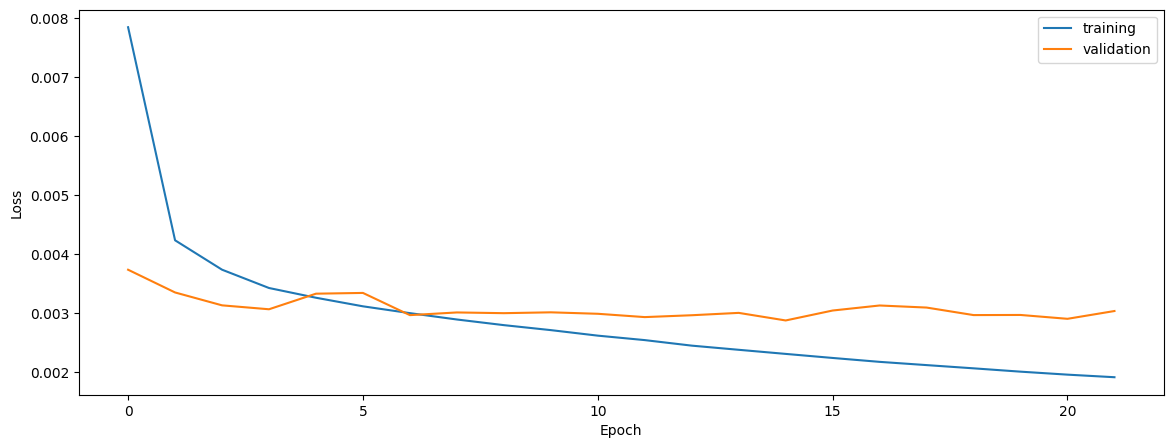

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.8762921512368377
0.8269005490215232
0.8259643075788997


In [8]:
print('normalized')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

normalized
0.8762921512368377
0.8269005490215232
0.8259643075788997


In [9]:
print('native')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

native
0.8747870547448162
0.8233953169196367
0.8246378190092825


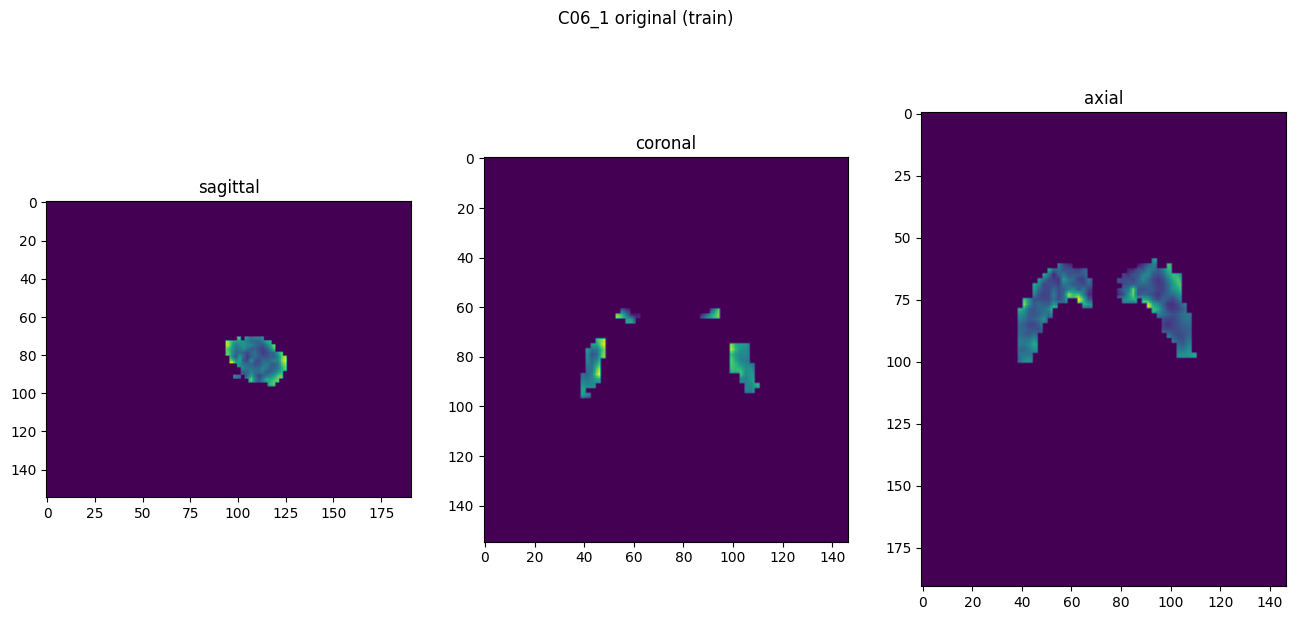

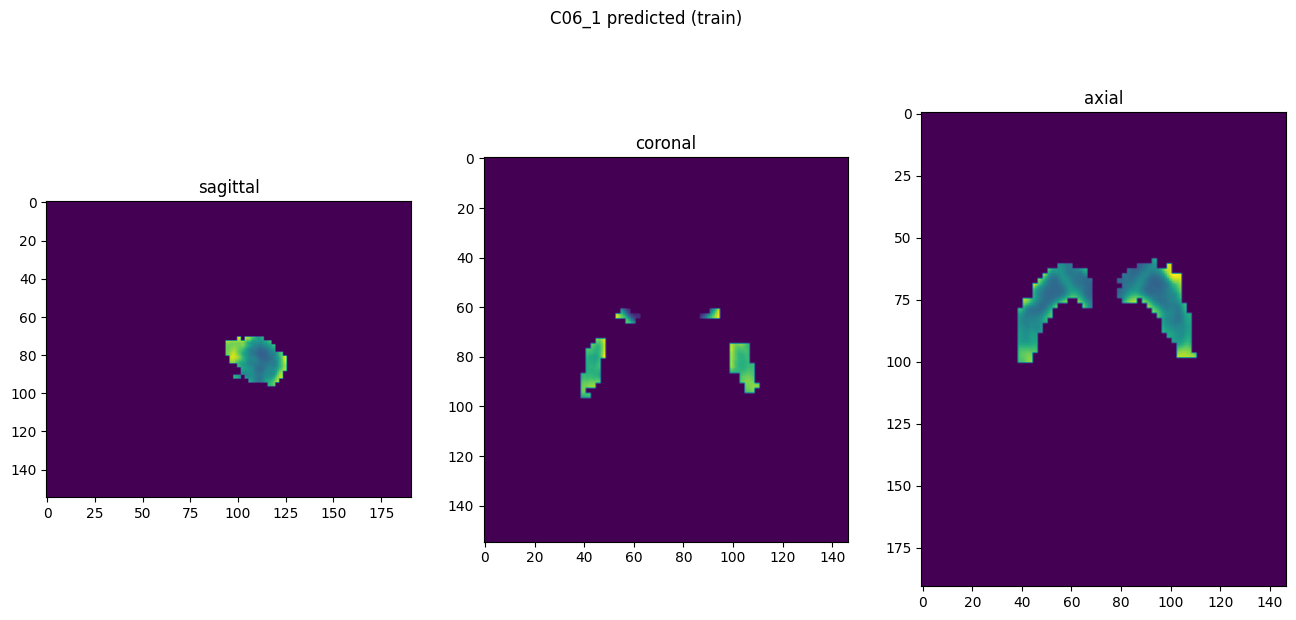

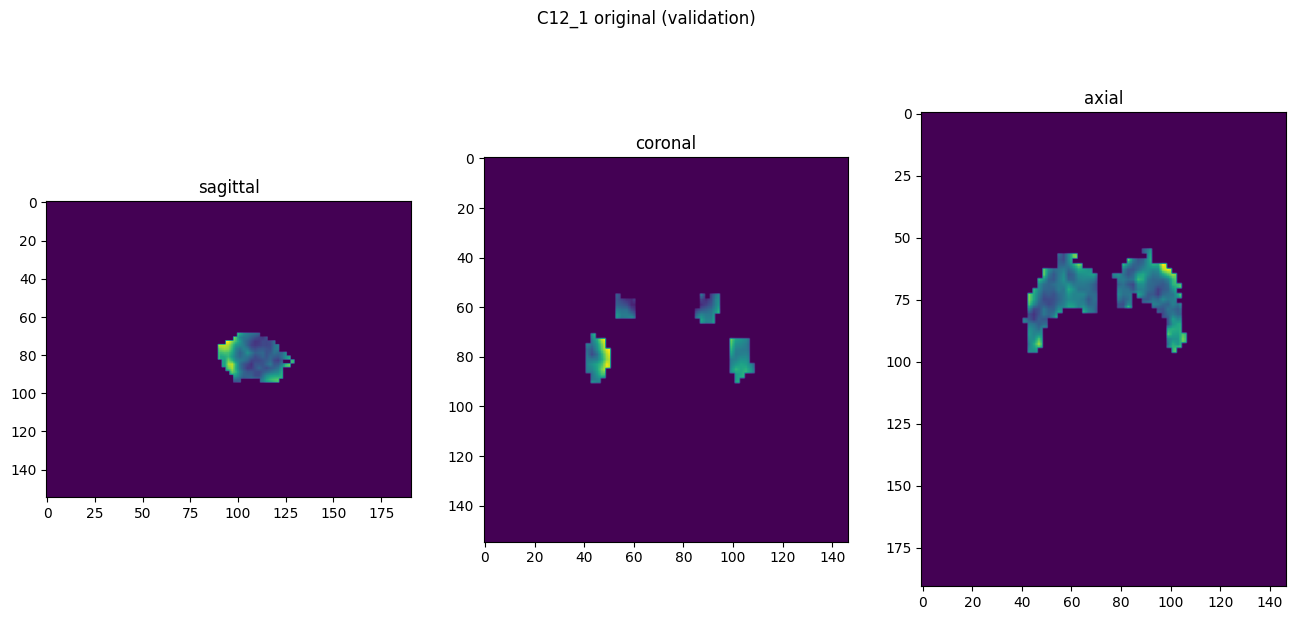

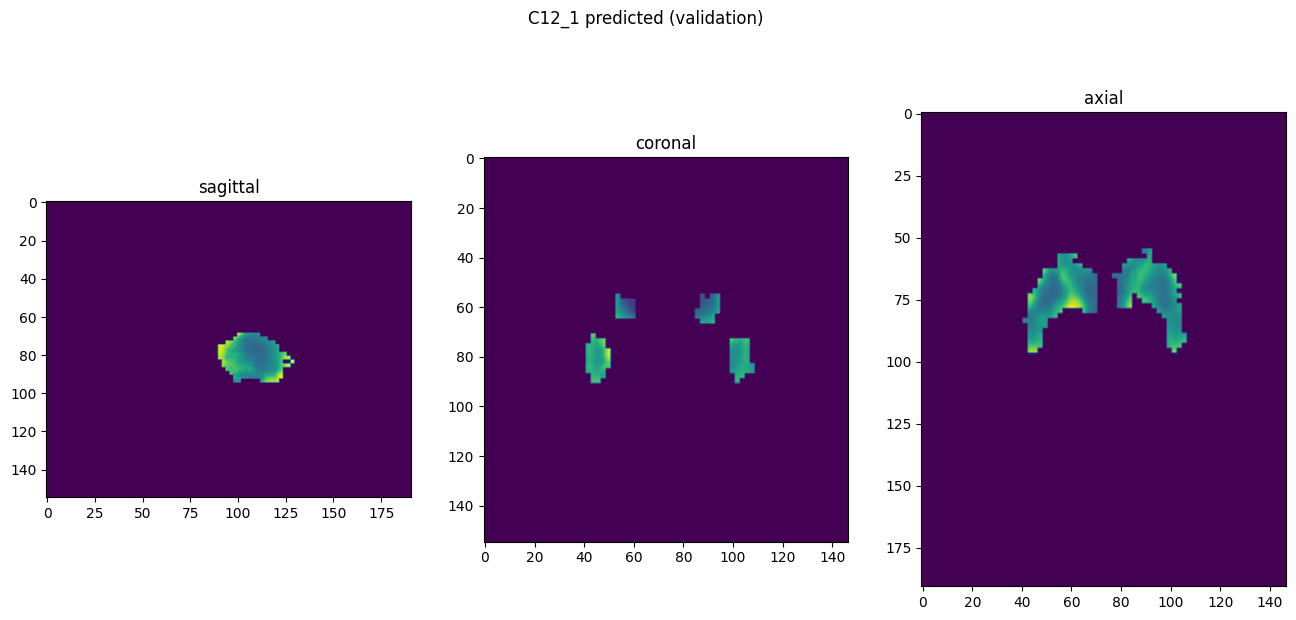

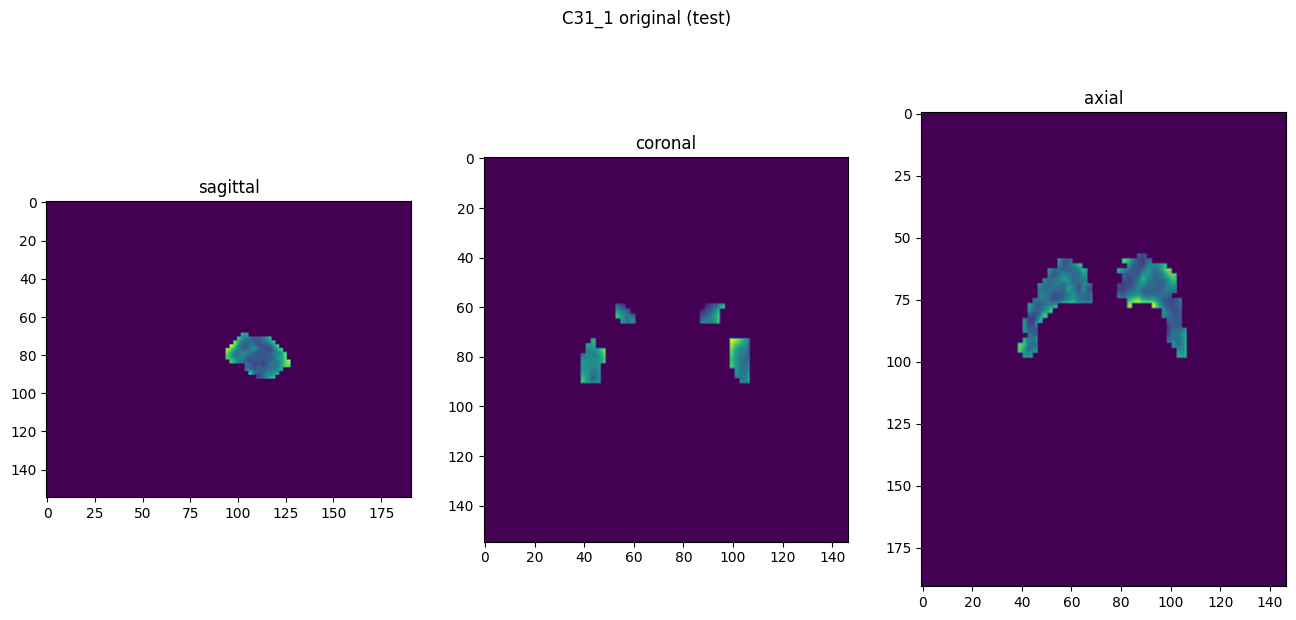

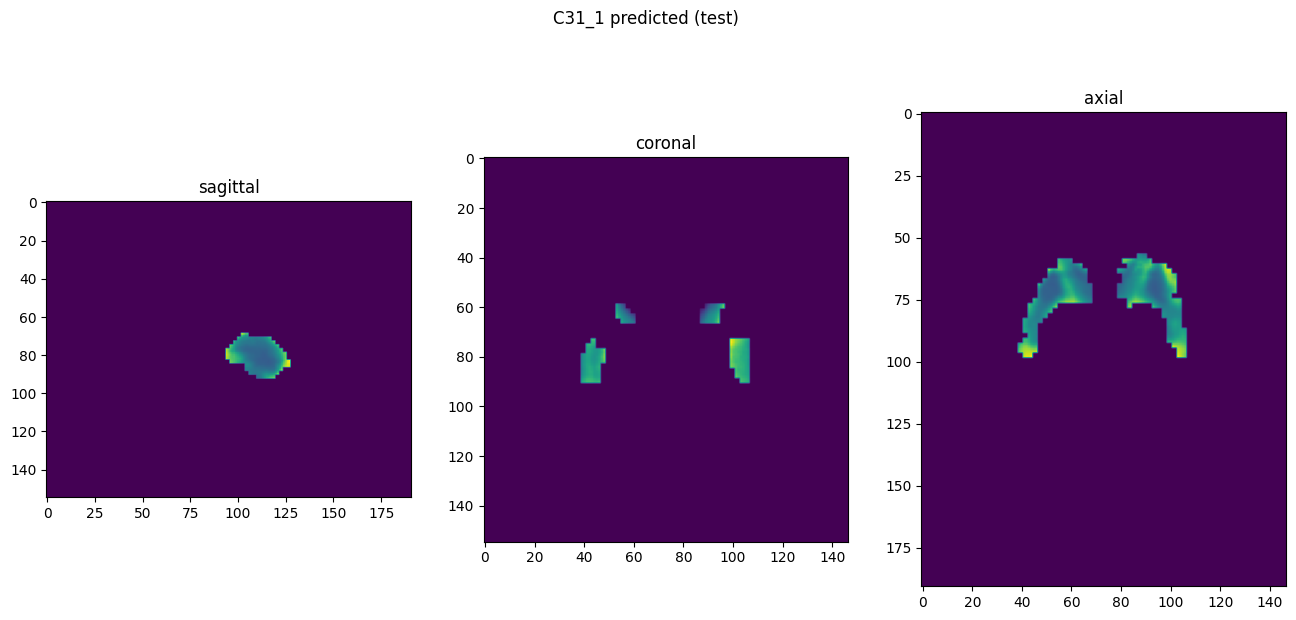

In [10]:
showResults(model, gen, threshold=None, background=False)